In [88]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [89]:
df = pd.read_csv('text.csv')

df.head()

,id,training_id,device_id,movement_id,repetition,timestamp,raw
0,1,1,1,1,1,2025-12-08T23:05:04.142018Z,"3248,3233,3233,2208,16,0,1345,2289,3121,3217,3..."
1,2,1,1,1,1,2025-12-08T23:05:04.245016Z,"3232,3232,65,1,929,2048,3008,3217,3233,3232,11..."
2,3,1,1,1,1,2025-12-08T23:05:04.348016Z,"2336,17,0,1569,2657,3217,3216,3217,3233,48,1,1..."
3,4,1,1,1,1,2025-12-08T23:05:04.451018Z,"0,784,2096,3104,3232,3249,3233,1136,32,512,179..."
4,5,1,1,1,1,2025-12-08T23:05:04.555016Z,"1697,2641,3217,3232,3233,3264,49,33,1233,2256,..."


In [90]:
df['movement_id'].unique

<bound method Series.unique of 0      1
1      1
2      1
3      1
4      1
      ..
730    3
731    3
732    3
733    3
734    3
Name: movement_id, Length: 735, dtype: int64>

In [91]:
df["raw_array"] = df["raw"].apply(lambda x: np.array(list(map(int, x.split(",")))))

In [92]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

movements = df["movement_id"].unique()
print("Movements:", movements)

m1, m2 = movements[0], movements[1]
print(f"Comparing movement {m1} vs {m2}")

df1 = df[df["movement_id"] == m1]
df2 = df[df["movement_id"] == m2]

A = np.vstack(df1["raw_array"].values)
B = np.vstack(df2["raw_array"].values)

meanA = A.mean(axis=0)
meanB = B.mean(axis=0)

meanA_norm = (meanA - meanA.mean()) / meanA.std()
meanB_norm = (meanB - meanB.mean()) / meanB.std()

cosine = cosine_similarity([meanA_norm], [meanB_norm])[0][0]
mse = np.mean((meanA_norm - meanB_norm)**2)
corr = np.corrcoef(meanA_norm, meanB_norm)[0, 1]

print("Cosine similarity:", cosine)
print("MSE:", mse)
print("Correlation:", corr)


Movements: [1 2 3]
Comparing movement 1 vs 2
Cosine similarity: 0.624220394081417
MSE: 0.7515592118371657
Correlation: 0.6242203940814172


Movements: [1 2 3]


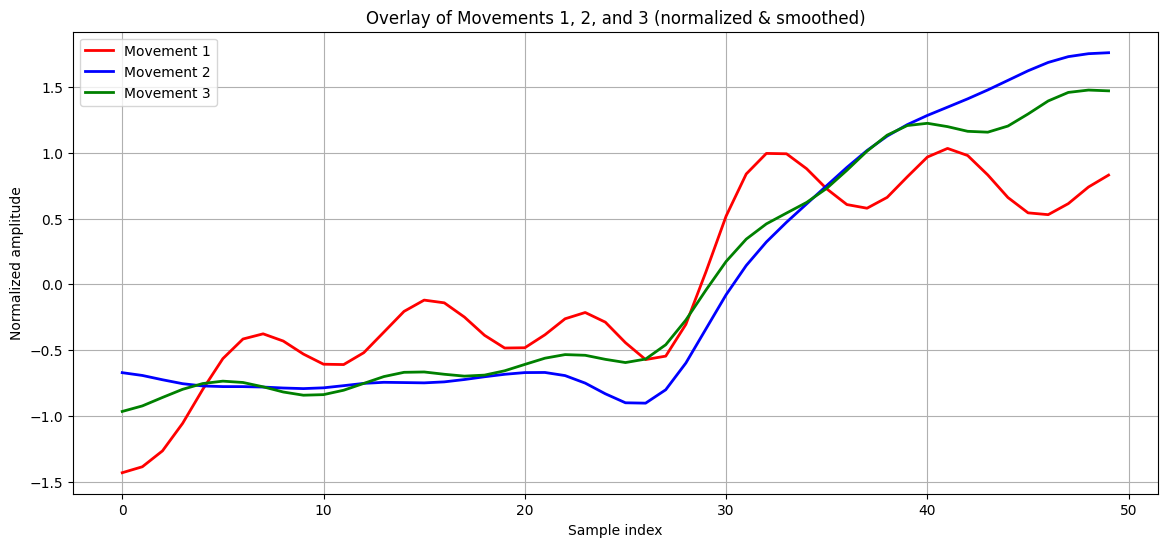

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

movements = df["movement_id"].unique()
print("Movements:", movements)

colors = ["red", "blue", "green"]
plt.figure(figsize=(14, 6))

for idx, m in enumerate(movements):
    df_m = df[df["movement_id"] == m]

    M = np.vstack(df_m["raw_array"].values)

    meanM = M.mean(axis=0)

    meanM_norm = (meanM - meanM.mean()) / meanM.std()

    meanM_smooth = gaussian_filter1d(meanM_norm, sigma=2)

    plt.plot(
        meanM_smooth,
        label=f"Movement {m}",
        color=colors[idx % len(colors)],
        linewidth=2
    )

plt.title("Overlay of Movements 1, 2, and 3 (normalized & smoothed)")
plt.xlabel("Sample index")
plt.ylabel("Normalized amplitude")
plt.grid(True)
plt.legend()
plt.show()


In [94]:
import sys
print(sys.executable)


/Users/diyar/learn/final/emg_esp32_classifier_ml/venv/bin/python


In [95]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical



In [96]:
df = pd.read_csv('text.csv')

In [97]:
df["raw_vec"] = df["raw"].apply(lambda s: np.array(list(map(int, s.split(",")))))

In [98]:
def mav(x): return np.mean(np.abs(x))
def rms(x): return np.sqrt(np.mean(x**2))
def wl(x): return np.sum(np.abs(np.diff(x)))
def var(x): return np.var(x)
def zero_cross(x): return np.sum((x[:-1] * x[1:]) < 0)
def ssc(x): return np.sum(np.diff(np.sign(np.diff(x))) != 0)
def iemg(x): return np.sum(np.abs(x))
def kf(x): return np.sqrt(np.sum(x**2)) / len(x)
def mean_freq(x): return np.mean(np.abs(np.fft.rfft(x)))
def peak_freq(x): return np.argmax(np.abs(np.fft.rfft(x)))


In [99]:
def extract_features(x):
    return np.array([
    mav(x),
    rms(x),
    wl(x),
    var(x),
    zero_cross(x),
    ssc(x),
    np.max(x),
    np.min(x),
    iemg(x),
    kf(x),
    mean_freq(x),
    peak_freq(x)
])


In [100]:
X = np.array([extract_features(v) for v in df["raw_vec"]])
y = to_categorical(df["movement_id"].values - 1, 3)


In [101]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [102]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [103]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(X.shape[1],)),
    BatchNormalization(),
    Dropout(0.25),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])


In [104]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True,
    mode='min'
)



In [105]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/200


2025-12-09 17:06:50.041137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 1s 37ms/step - loss: 0.8487 - accuracy: 0.6574 - val_loss: 0.5570 - val_accuracy: 0.7288
Epoch 2/200
 1/15 [=>............................] - ETA: 0s - loss: 0.8627 - accuracy: 0.6250

2025-12-09 17:06:50.767477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 0s 17ms/step - loss: 0.6009 - accuracy: 0.6894 - val_loss: 0.5532 - val_accuracy: 0.6610
Epoch 3/200
15/15 [==============================] - 0s 16ms/step - loss: 0.5950 - accuracy: 0.6851 - val_loss: 0.5652 - val_accuracy: 0.6102
Epoch 4/200
15/15 [==============================] - 0s 14ms/step - loss: 0.5273 - accuracy: 0.7064 - val_loss: 0.5053 - val_accuracy: 0.7542
Epoch 5/200
15/15 [==============================] - 0s 15ms/step - loss: 0.5175 - accuracy: 0.7043 - val_loss: 0.5560 - val_accuracy: 0.6102
Epoch 6/200
15/15 [==============================] - 0s 12ms/step - loss: 0.5293 - accuracy: 0.6979 - val_loss: 0.5515 - val_accuracy: 0.6525
Epoch 7/200
15/15 [==============================] - 0s 13ms/step - loss: 0.4951 - accuracy: 0.7128 - val_loss: 0.4977 - val_accuracy: 0.6186
Epoch 8/200
15/15 [==============================] - 0s 13ms/step - loss: 0.5109 - accuracy: 0.7128 - val_loss: 0.5085 - val_accuracy: 0.6356
Epoch 9/200
15/15 

In [106]:
loss, acc = model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 11ms/step - loss: 0.4353 - accuracy: 0.7551


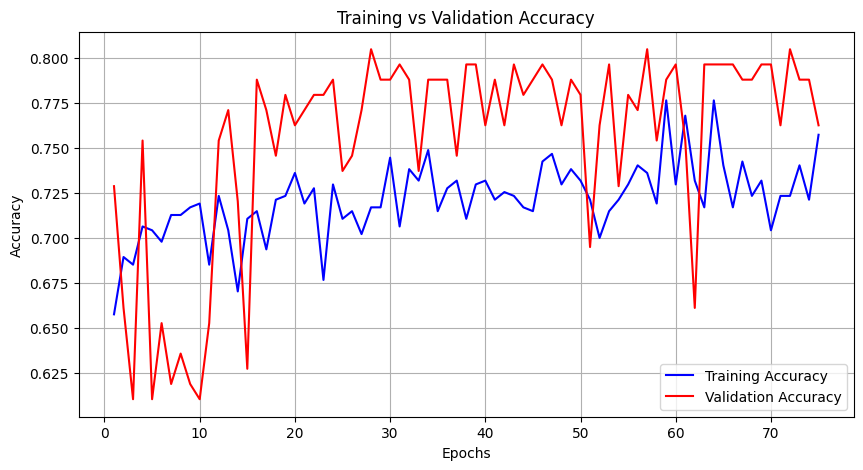

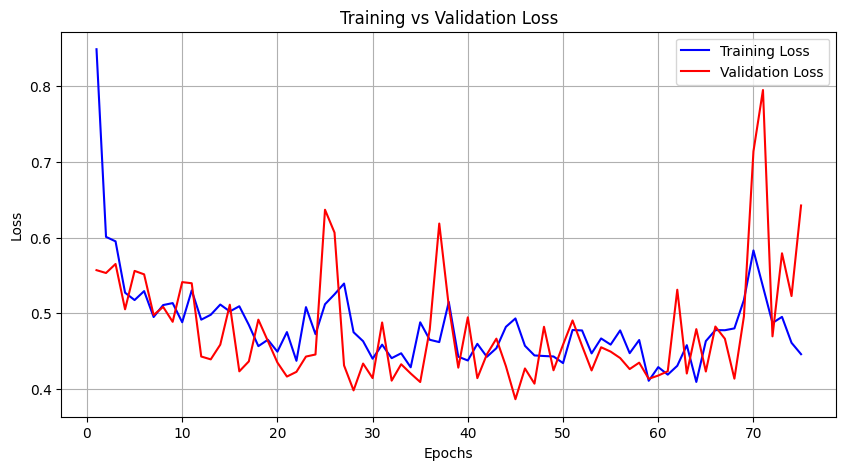

In [110]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10,5))
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [107]:
model.save("emg_ann_compat.keras", save_format="keras")

model.save("emg_ann_compat.h5")

/Users/diyar/learn/final/emg_esp32_classifier_ml/venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [108]:
print(acc)

0.7551020383834839


In [112]:
y_labels = np.argmax(y, axis=1) 

In [ ]:
def build_model(input_dim):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.25),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [113]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

train_sizes = [0.2, 0.4, 0.6, 0.8]
val_accs = []

for size in train_sizes:
    X_train, X_val, y_train, y_val = train_test_split(
        X_scaled, y, test_size=1-size, random_state=42, stratify=y_labels
    )

    model = build_model(X_scaled.shape[1])

    history = model.fit(
        X_train, y_train,
        epochs=200,
        batch_size=32,
        validation_data=(X_val, y_val),
        verbose=0,
        callbacks=[EarlyStopping(monitor='val_loss',
                                 patience=20,
                                 restore_best_weights=True,
                                 mode='min')]
    )

    loss, acc = model.evaluate(X_val, y_val, verbose=0)
    val_accs.append(acc)

plt.plot([int(s*100) for s in train_sizes], val_accs, marker='o')
plt.xlabel("Train data used (%)")
plt.ylabel("Validation accuracy")
plt.title("Learning curve")
plt.grid(True)
plt.show()


NameError: name 'build_model' is not defined